In [1]:
import os
import json
from pathlib import Path

def check_log_for_success(log_file_path):
    """
    檢查 log 檔案是否包含 'Received PDU Session Establishment Accept'
    """
    try:
        # 建議優化：逐行讀取以節省記憶體
        with open(log_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                if 'Received PDU Session Establishment Accept' in line:
                    return True
            return False
    except Exception as e:
        print(f"Error reading {log_file_path}: {e}")
        return None

def analyze_directory(directory_path):
    """
    分析目錄並統計錯誤與成功案例
    """
    error_count, success_count = 0, 0
    error_files, success_files = [], []
    
    if not os.path.exists(directory_path):
        print(f"Warning: Directory does not exist: {directory_path}")
        return 0, 0, [], []
    
    for filename in sorted(os.listdir(directory_path)):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            has_success = check_log_for_success(file_path)
            
            if has_success is None: continue
            if not has_success:
                error_count += 1
                error_files.append(filename)
            else:
                success_count += 1
                success_files.append(filename)
    
    return error_count, success_count, error_files, success_files

In [2]:
# 定義基礎目錄
base_dir = r'C:\Users\wasd0\Desktop\Testing_Row_Data'

# 定義要檢查的 Option 1 與 Option 2 路徑
directories = {
    'Option 1': [
        os.path.join(base_dir, 'option_1', 'merge', 'op1_100_case_1'),
        os.path.join(base_dir, 'option_1', 'merge', 'op1_100_case_2'),
    ],
    'Option 2': [
        os.path.join(base_dir, 'option_2', 'merge', 'op2_100_case_1'),
        os.path.join(base_dir, 'option_2', 'merge', 'op2_100_case_2'),
    ]
}

In [3]:
overall_stats = {}

for option_name, dir_list in directories.items():
    print(f"\n{'='*30} {option_name.upper()} {'='*30}")
    option_errors, option_success = 0, 0
    
    for directory in dir_list:
        dir_name = os.path.basename(directory)
        e_cnt, s_cnt, e_files, s_files = analyze_directory(directory)
        
        option_errors += e_cnt
        option_success += s_cnt
        total = e_cnt + s_cnt
        
        print(f"\n[{dir_name}] - Total: {total}")
        if total > 0:
            print(f"  Error: {e_cnt} ({e_cnt/total*100:.1f}%) | Success: {s_cnt} ({s_cnt/total*100:.1f}%)")
        
        if e_files:
            print(f"  Error Examples: {', '.join(e_files[:3])} ...")

    overall_stats[option_name] = {'errors': option_errors, 'success': option_success}


============================== OPTION 1 ==============================

[op1_100_case_1] - Total: 100
  Error: 31 (31.0%) | Success: 69 (69.0%)
  Error Examples: option_1_case_13_logs.json, option_1_case_14_logs.json, option_1_case_15_logs.json ...

[op1_100_case_2] - Total: 100
  Error: 25 (25.0%) | Success: 75 (75.0%)
  Error Examples: option_1_case_10_logs.json, option_1_case_11_logs.json, option_1_case_16_logs.json ...

============================== OPTION 2 ==============================

[op2_100_case_1] - Total: 100
  Error: 73 (73.0%) | Success: 27 (27.0%)
  Error Examples: option_2_case_100_logs.json, option_2_case_10_logs.json, option_2_case_11_logs.json ...

[op2_100_case_2] - Total: 100
  Error: 61 (61.0%) | Success: 39 (39.0%)
  Error Examples: option_2_case_100_logs.json, option_2_case_14_logs.json, option_2_case_15_logs.json ...


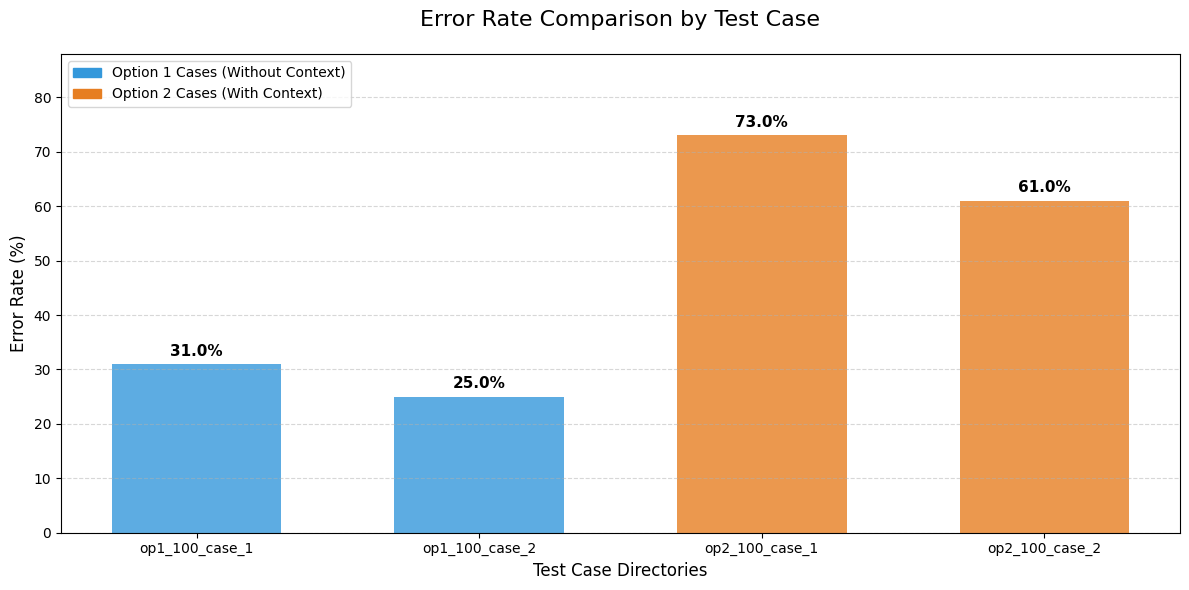

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # 改用 patches 來處理圖例顏色塊

# 1. 準備細分數據
case_names = []
error_rates = []
colors = []

# 從之前的分析結果提取數據
for option_name, dir_list in directories.items():
    for directory in dir_list:
        dir_name = os.path.basename(directory)
        # 呼叫分析函數獲取該目錄的數據
        e_cnt, s_cnt, _, _ = analyze_directory(directory)
        
        total = e_cnt + s_cnt
        rate = (e_cnt / total * 100) if total > 0 else 0
        
        case_names.append(dir_name)
        error_rates.append(rate)
        
        # 區分顏色：Option 1 用藍色，Option 2 用橘色
        colors.append('#3498db' if 'option_1' in directory.lower() else '#e67e22')

# 2. 開始繪圖
plt.figure(figsize=(12, 6))
bars = plt.bar(case_names, error_rates, color=colors, alpha=0.8, width=0.6)

# 3. 圖表格式設定
plt.title('Error Rate Comparison by Test Case', fontsize=16, pad=20)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.xlabel('Test Case Directories', fontsize=12)
plt.ylim(0, max(error_rates) + 15 if error_rates else 100) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 4. 在長條圖上方標註具體百分比
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 5. 添加圖例說明 (使用 mpatches 修正 ImportError)
patch1 = mpatches.Patch(color='#3498db', label='Option 1 (Without Context)')
patch2 = mpatches.Patch(color='#e67e22', label='Option 2 (With Context)')
plt.legend(handles=[patch1, patch2], loc='upper left')

plt.tight_layout()
plt.show()